In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


trainging_data = datasets.FashionMNIST(
    root = "../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



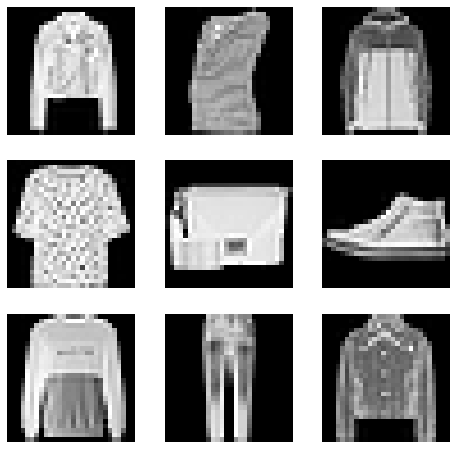

In [2]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainging_data), size=(1,)).item()
    img, label = trainging_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
print(trainging_data[3][0].shape)
print(trainging_data[3][1])

torch.Size([1, 28, 28])
3


In [9]:
class CustomDataset(Dataset):

    def __init__(self):
        self.x_data = [[73, 80, 75], [93, 88, 93], [89, 91, 90], [96, 98, 100], [73, 66, 70]]
        self.y_data = [[152], [185], [180], [196], [142]]

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x_data[idx])
        y = torch.FloatTensor(self.y_data[idx])
        return x, y


In [12]:
from torchvision.transforms import Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(
        0, torch.tensor(y), value=1
    ))
)

print(ds[3][0].shape)
print(ds[3][1])

torch.Size([1, 28, 28])
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


In [13]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose

torchvision_transform = Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = CustomDataset(
    path = 'images/',
    transform = torchvision_transform
)

TypeError: __init__() got an unexpected keyword argument 'path'

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainging_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


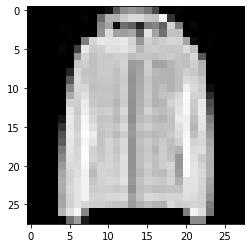

Label: 4


In [15]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [22]:
import torch.nn.functional as F

class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            # torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)
lr = 0.001
epochs = 20
model = MLP().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

device:  cuda


In [24]:
for epoch in range(epochs):
    for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
        # tarin
        model.train()
        optimizer.zero_grad()
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        pred = model(X_train)
        loss = criterion(pred, y_train)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            loss, current = loss.item(), batch_idx * len(X_train)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")
    
    test_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dataloader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            pred = model(X_test)
            test_loss += criterion(pred, y_test).item()
            correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
        test_loss /= len(test_dataloader)
        correct /= len(test_dataloader.dataset)
        print(f"Test Error: \n Accurach: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss: 2.296057  [    0/60000]
loss: 2.283111  [ 6400/60000]
loss: 2.272609  [12800/60000]
loss: 2.269556  [19200/60000]
loss: 2.242112  [25600/60000]
loss: 2.222144  [32000/60000]
loss: 2.202272  [38400/60000]
loss: 2.192159  [44800/60000]
loss: 2.155325  [51200/60000]
loss: 2.137113  [57600/60000]
Test Error: 
 Accurach: 49.3%, Avg loss: 2.143579 

loss: 2.148298  [    0/60000]
loss: 2.123630  [ 6400/60000]
loss: 2.083555  [12800/60000]
loss: 2.114607  [19200/60000]
loss: 2.047505  [25600/60000]
loss: 2.021230  [32000/60000]
loss: 1.995720  [38400/60000]
loss: 1.889124  [44800/60000]
loss: 1.910400  [51200/60000]
loss: 1.931795  [57600/60000]
Test Error: 
 Accurach: 60.6%, Avg loss: 1.859995 

loss: 1.847178  [    0/60000]
loss: 1.878178  [ 6400/60000]
loss: 1.838770  [12800/60000]
loss: 1.768265  [19200/60000]
loss: 1.651259  [25600/60000]
loss: 1.592915  [32000/60000]
loss: 1.613240  [38400/60000]
loss: 1.598774  [44800/60000]
loss: 1.544999  [51200/60000]
loss: 1.475108  [57600/600

In [25]:
import torchvision.models as models

torch.save(model.state_dict(), 'model_no_normalization_wieghts.pth')

In [27]:
model_no_normalization = MLP().to(device)
model_no_normalization.load_state_dict(torch.load('model_no_normalization_wieghts.pth'))
model_no_normalization.eval()

MLP(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [21]:
with torch.no_grad():
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        pred = model(X_test)
        test_loss += criterion(pred, y_test).item()
        correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
    test_loss /= len(test_dataloader)
    correct /= len(test_dataloader.dataset)
    print(f"Test Error: \n Accurach: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accurach: 87.1%, Avg loss: 0.363194 



In [28]:
with torch.no_grad():
    for X_test, y_test in test_dataloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        pred = model_no_normalization(X_test)
        test_loss += criterion(pred, y_test).item()
        correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
    test_loss /= len(test_dataloader)
    correct /= len(test_dataloader.dataset)
    print(f"Test Error: \n Accurach: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Test Error: 
 Accurach: 78.6%, Avg loss: 0.624785 

